In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


from scipy.signal import correlate

from tqdm.notebook import tqdm

import h5py

import sys
sys.path.append("..")
import models
import data
import inference

%load_ext autoreload
%autoreload 2

In [2]:
# Figure 10
# dx = 20

# Figure 11
dx = 20

nx = 32
nx_width = 4
nx_stride = 3
if dx == 4:
    nx = 128
    nx_width = 16
    nx_stride = 12
nt = 512

In [3]:
def semblance(data):
    nx, nt = data.shape
    # cross correlate and shift
    for i in range(nx-1):
        data = moveout_correction(data, i)
    
    return np.sum(np.sum(data, axis=0)**2) / np.sum(data**2) / nx

def moveout_correction(x, idx, thresh=0.7):
    # N = 2 * len(x[idx]) - 1
    # X = np.fft.fft(x[idx], n=N)
    # Y = np.fft.fft(x[idx+1], n=N)
    # corr = np.fft.fftshift(np.fft.ifft(X*Y.conj()).real)
    corr = correlate(x[idx], x[idx+1], mode='full') # (2 * len(x) - 1,)
    shift = np.argmax(corr) - (len(x[idx]) - 1)
    
    ashift = abs(shift)
    pad1 = np.zeros((idx+1, ashift))
    pad2 = np.zeros((x.shape[0] - (idx+1), ashift))
    if shift > 0 and np.corrcoef(x[idx,shift:], x[(idx+1),:-shift], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([x[:(idx+1)], pad1], axis=1),
             np.concatenate([pad2, x[(idx+1):]], axis=1)],
            axis=0)
    if shift < 0 and np.corrcoef(x[idx,:-shift], x[(idx+1),shift:], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([pad1, x[:(idx+1)]], axis=1),
             np.concatenate([x[(idx+1):], pad2], axis=1)],
            axis=0)
    return x

def moving_window_semblance(data, size=(15,25)):
    
    nx, nt = data.shape
    result = np.zeros((nx-size[0]+1, nt-size[1]+1))
    
    for i in tqdm(range(result.shape[0])):
        for j in range(result.shape[1]):
            result[i,j] = semblance(data[i:i+size[0],j:j+size[1]])
    
    return result

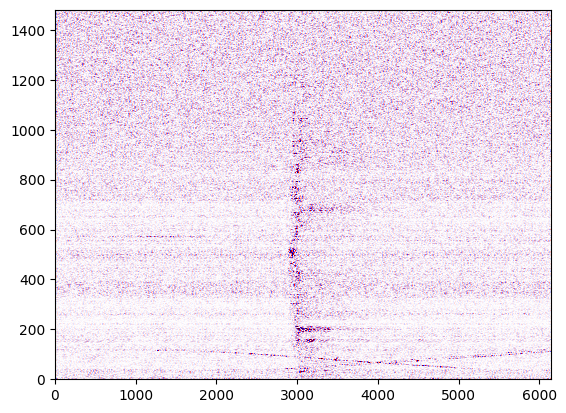

In [4]:
fs = 50.0

#file = '../data/preprocessed/real_test/2023p273854.h5'
#file = '../../Server_DAS/eq_data_50Hz/2023p273854/south30_50Hz_UTC_20230412_075007.359.h5'
file = "2023p273854.h5"
idx = 5500

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

if dx == 20:
    samples = samples[::5]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('data_tmp/2023p273854_input{}.npy'.format(dx), x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [3]:
# Liste der Dateien, die gemerged werden sollen
h5_files = ['../../Server_DAS/eq_data_50Hz/2023p273854/south30_50Hz_UTC_20230412_074807.359.h5', '../../Server_DAS/eq_data_50Hz/2023p273854/south30_50Hz_UTC_20230412_074907.359.h5', '../../Server_DAS/eq_data_50Hz/2023p273854/south30_50Hz_UTC_20230412_075007.359.h5', '../../Server_DAS/eq_data_50Hz/2023p273854/south30_50Hz_UTC_20230412_075107.359.h5']

# Neue Datei, in der die gemergten Daten gespeichert werden
merged_file = '2023p273854.h5'

# Annahme: Alle Dateien haben einen Datensatz mit dem Namen "DAS_data"
dataset_name = 'DAS'

# Leere Liste zum Speichern der Daten
data_list = []

# Lade die Daten aus jeder Datei und füge sie der Liste hinzu
for file in h5_files:
    with h5py.File(file, 'r') as h5f:
        data = h5f[dataset_name][:]
        data_list.append(data)

# Kombiniere die Daten (hier entlang der ersten Dimension, z.B. Zeit)
merged_data = np.concatenate(data_list, axis=0)
merged_data = merged_data.T

# Speichere die gemergten Daten in einer neuen HDF5-Datei
with h5py.File(merged_file, 'w') as h5f_out:
    h5f_out.create_dataset(dataset_name, data=merged_data)

print(f"Datei {merged_file} wurde erfolgreich erstellt!")

Datei 2023p273854.h5 wurde erfolgreich erstellt!


In [ ]:
print("skip 5")

In [20]:
# Calculate N2S reconstruction
from import_files import Sebastian_N2SUNet


#model = models.N2SUNet(1, 1, 4).to(device)
#model.load_state_dict(torch.load('N2S-synthetic20-11x2048-1x2048_200.pt'.format(dx, 11 + 3*11* (dx == 4), 1 + 3* (dx == 4))))
model = Sebastian_N2SUNet(1, 1, 4).to(device)
model.load_state_dict(torch.load("transfer37_sebastian.pth", map_location=device))

model.eval()
"""
if dx == 20:
    rec = inference.channelwise_reconstruct(model, torch.from_numpy(x).to(device), nx=11, nt=2048)
else:
    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 44, 2048, 4, nx_stride=4, nt_stride=512, batch_size=128, dx=dx, verbose=False, ende=True)
rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
"""
def channelwise_mask(x, width=1, indices=None):

    batch_size, _, nx, nt = x.shape
    mask = torch.ones_like(x)
    u = int(np.floor(width/2))
    l = int(np.ceil(width/2))
    if indices is None:
        indices = torch.randint(u, nx - l, (batch_size,))
    for i in range(batch_size):
        mask[i, :, indices[i]-u:indices[i]+l] = 0
    
    return (1-mask)
def reconstruct(model, device, noise_images):
    dasChanelsTrain = 11
    maskChanels = 1
    buffer = torch.zeros_like(noise_images).to(device)
    training_size = dasChanelsTrain # 11 how much chanels were used for training
    num_chunks = noise_images.shape[2] // training_size
    left_chunks = noise_images.shape[2] % training_size
    for chunk_idx in range(num_chunks):
        # Extract the chunk from the larger picture
        start_idx = chunk_idx * training_size
        chunk = noise_images[:, :, start_idx:start_idx+training_size, :]
        for i in range(training_size):
            """
            mask = torch.zeros_like(chunk).to(device)
            mask[:, :, i, :] = 1  # Mask out the i-th channel
            """
            mask = channelwise_mask(chunk, width=maskChanels, indices=np.full(chunk.shape[0], i))
            input_image = chunk * (1 - mask)
            j_denoised = model(input_image)
            buffer[:, :, start_idx:start_idx+training_size, :] += j_denoised * mask
    # calculate the left overs when chanels are not a multiplicative of training_size
    for i in range(left_chunks):
        chunk = noise_images[:, :, noise_images.shape[2]-dasChanelsTrain:, :]
        mask = torch.zeros_like(chunk).to(device)
        mask[:, :, training_size-i-1, :] = 1
        input_image = chunk * (1 - mask)
        j_denoised = model(input_image)
        buffer[:, :, noise_images.shape[2]-dasChanelsTrain:, :] += j_denoised * mask
    return buffer
rec_filt = reconstruct(model, device, torch.from_numpy(x.reshape(1, 1, *x.shape)).to(device, dtype=torch.float))
np.save('data_tmp/2023p273854_N2S{}.npy'.format(dx), rec_filt)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 22.49 GiB is allocated by PyTorch, and 62.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
t = x.reshape(1, 1, *x.shape)
t

array([[[[ 0.10565829,  0.23883298,  0.24864004, ..., -1.12849858,
          -1.04310399, -0.60545636],
         [-1.01019741, -0.74765967, -0.36222015, ..., -1.45558951,
          -0.71508371,  0.44878493],
         [ 1.18019691,  0.28910173, -1.57852797, ...,  0.35765118,
           0.35439514,  0.06920597],
         ...,
         [-0.26256911, -0.0299158 ,  0.72463613, ..., -0.78295772,
          -0.42344353,  0.20310279],
         [ 0.97478506,  1.7150581 ,  1.60751509, ..., -0.18740071,
           0.1277718 , -0.05643168],
         [-2.05208365, -2.09508376, -1.34193912, ...,  0.4051671 ,
          -0.44129802, -0.898199  ]]]])

In [12]:
print("skip 7")
n2s = np.load("data_tmp/2023p273854_N2S20.npy".format(dx))[:,2000:4000]

skip 7


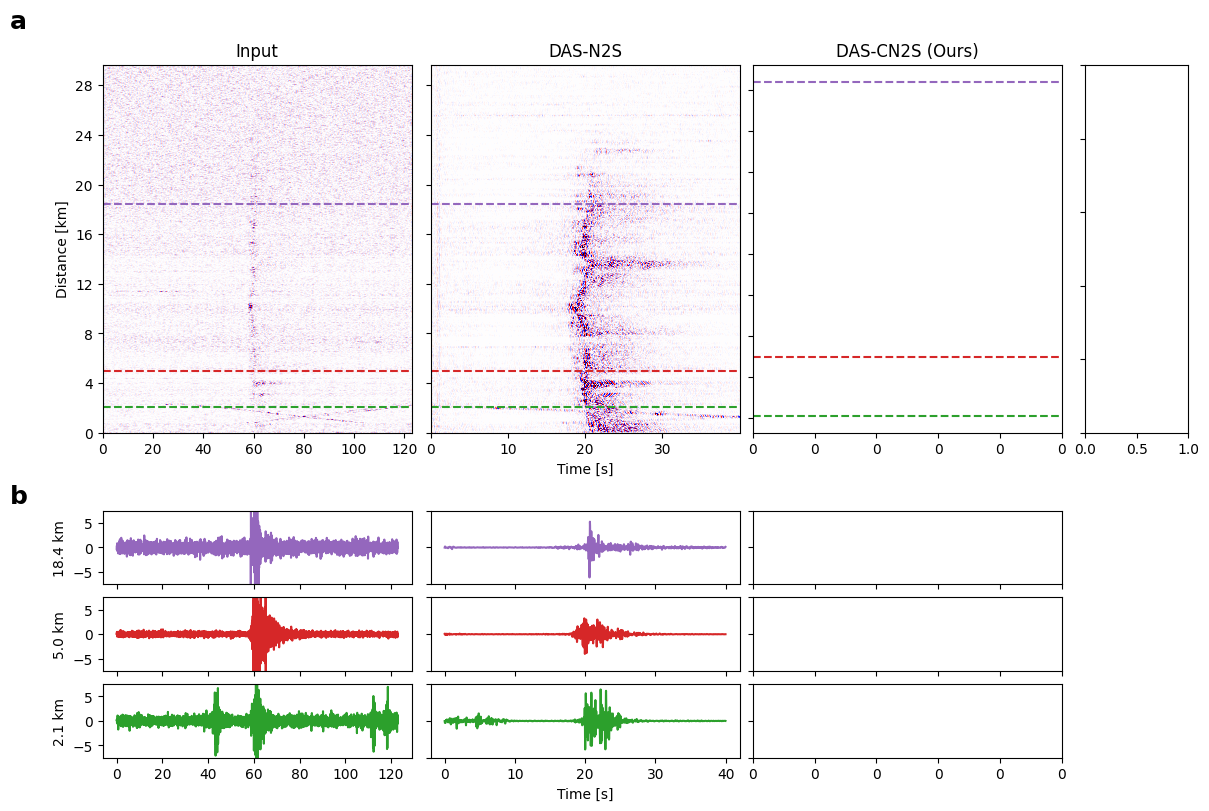

In [13]:
fig, axs = plt.subplot_mosaic([['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a','a','a','b','b','b','c','c','c','d'],
                               ['a1', 'a1', 'a1', 'b1', 'b1', 'b1', 'c1', 'c1', 'c1', 'd1'],
                               ['a2', 'a2', 'a2', 'b2', 'b2', 'b2', 'c2', 'c2', 'c2', 'd2'],
                               ['a3', 'a3', 'a3', 'b3', 'b3', 'b3', 'c3', 'c3', 'c3', 'd3']],
                              layout='constrained', figsize=(12,8))

v = 1
axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 0.001 * dx))}')) 

axs['b'].imshow(n2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
#axs['b'].set_yticklabels([])
#axs['c'].imshow(cn2s, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-v, vmax=v)
#axs['c'].set_yticklabels([])

ch1 = 105 * 20 // dx
ch2 = 250 * 20 // dx
ch3 = 920 * 20 // dx

for s in ['a', 'b', 'c']:
    axs[s].axhline(ch1, ls="--", c="tab:green")
    axs[s].axhline(ch2, ls="--", c="tab:red")
    axs[s].axhline(ch3, ls="--", c="tab:purple")
    
axs['a1'].plot(x[ch3], color='tab:purple')
axs['a2'].plot(x[ch2], color='tab:red')
axs['a3'].plot(x[ch1], color='tab:green')
axs['b1'].plot(n2s[ch3], color='tab:purple')
axs['b2'].plot(n2s[ch2], color='tab:red')
axs['b3'].plot(n2s[ch1], color='tab:green')
"""
axs['c1'].plot(cn2s[ch3], color='tab:purple')
axs['c2'].plot(cn2s[ch2], color='tab:red')
axs['c3'].plot(cn2s[ch1], color='tab:green')
"""
axs['a1'].set_ylabel("{:.1f} km".format(ch3*dx / 1000))
axs['a2'].set_ylabel("{:.1f} km".format(ch2*dx / 1000))
axs['a3'].set_ylabel("{:.1f} km".format(ch1*dx / 1000))

for s in ['a', 'b', 'c', 'a1', 'b1', 'c1', 'a2', 'b2', 'c2', 'a3', 'b3', 'c3']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))
for s in ['a1', 'b1', 'c1', 'a2', 'b2', 'c2']:
    axs[s].set_xticklabels([])
for s in ['b1', 'b2', 'b3', 'c1', 'c2', 'c3']:
    axs[s].set_yticklabels([])    

for s in ['a1', 'a2', 'a3']:
    axs[s].set_ylim((-7.5,7.5))
for s in ['b1', 'b2', 'b3']:
    axs[s].set_ylim((-5,5))
for s in ['c1', 'c2', 'c3']:
    axs[s].set_ylim((-2.5,2.5))

axs['d1'].axis('off')
axs['d2'].axis('off')
axs['d3'].axis('off')

axs['a'].set_ylabel('Distance [km]')

axs['b'].set_xlabel('Time [s]')
axs['b3'].set_xlabel('Time [s]')
axs['b'].set_yticklabels([])
axs['c'].set_yticklabels([])
axs['d'].set_yticklabels([])

axs['a'].set_title('Input')
axs['b'].set_title('DAS-N2S')
axs['c'].set_title('DAS-CN2S (Ours)')

#f1 = np.mean(S_N2S / S_input, axis=-1)
#f2 = np.mean(S_CN2S / S_input, axis=-1)
"""
if dx == 4:
    f1 = np.convolve(f1, np.ones(pad)/pad, mode='same')[pad-7:-(pad-7)]
    f2 = np.convolve(f2, np.ones(pad)/pad, mode='same')[pad-7:-(pad-7)]
else:
    f1 = np.convolve(f1, np.ones(pad)/pad, mode='same')[pad-1:-(pad-1)]
    f2 = np.convolve(f2, np.ones(pad)/pad, mode='same')[pad-1:-(pad-1)]

axs['d'].axvline(1, ls="--", c="gray")
axs['d'].plot(f1, np.arange(x.shape[0]), c="tab:blue", label='DAS-N2S')
axs['d'].plot(f2, np.arange(x.shape[0]), c="tab:orange", label='DAS-CN2S')
axs['d'].set_xlim((0, 10))
axs['d'].set_ylim((0, x.shape[0]))
axs['d'].set_xlabel('Avg. local SNR gain')
axs['d'].legend(bbox_to_anchor=(0.4, 1.05))
"""

axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['a1'].text(-0.3, 1.1, 'b', transform=axs['a1'].transAxes, size=18, weight='bold')

#if dx == 20:
    #plt.savefig('./out/figure_10.pdf', bbox_inches='tight', dpi=200)
#else:
    #plt.savefig('./out/figure_11.pdf', bbox_inches='tight', dpi=200)
plt.show()